# Fortum Energy Forecasting
Creating a lightgbm model that predicts energy consumption across 112 groups from Fortum's training dataset. This is an extension of Junction 2025.

In [7]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
color_pal = sns.color_palette()

import lightgbm as lgb

from sklearn.model_selection import TimeSeriesSplit


In [8]:
file_path = "/home/anton_s/MyEnergy/EnergyForecastFinal/data/20251111_JUNCTION_training.xlsx"
groups_df = pd.read_excel(file_path, sheet_name="groups")
prices_df = pd.read_excel(file_path, sheet_name="training_prices")
df = pd.read_excel(file_path, sheet_name="training_consumption")

# Convert to long format using melt
df = df.melt(
    id_vars=['measured_at'],
    var_name='group_id',
    value_name='consumption'
)

df['measured_at'] = pd.to_datetime(df['measured_at'])
prices_df['measured_at'] = pd.to_datetime(prices_df['measured_at'])

df = pd.merge(df, prices_df, on='measured_at', how='left')

# 5. Viimeistely (Indeksointi ja tyypitys)
df['group_id'] = df['group_id'].astype('category')

# Asetetaan indeksi vasta lopuksi, kun yhdistäminen on tehty
df = df.set_index('measured_at')
df = df.sort_index()

# TARKISTUS
print(f"Puuttuvat hinnat: {df['eur_per_mwh'].isna().sum()}")
print(df.head())

Puuttuvat hinnat: 26656
                          group_id  consumption  eur_per_mwh
measured_at                                                 
2021-01-01 00:00:00+00:00       28     7.010736        24.35
2021-01-01 00:00:00+00:00      694     0.205273        24.35
2021-01-01 00:00:00+00:00      196     0.185116        24.35
2021-01-01 00:00:00+00:00      693     7.736092        24.35
2021-01-01 00:00:00+00:00      197     0.448991        24.35


In [9]:
missing_prices = df[df['eur_per_mwh'].isna()]

print(f"Puuttuvia rivejä yhteensä: {len(missing_prices)}")

# 2. Katsotaan, miltä aikaväliltä puuttuvat tiedot ovat
if len(missing_prices) > 0:
    print(f"Ongelma alkaa:  {missing_prices.index.min()}")
    print(f"Ongelma loppuu: {missing_prices.index.max()}")
else:
    print("Ei puuttuvia hintoja.")

# 3. Verrataan sitä hintadatan alkuperäiseen pituuteen
print("-" * 30)
print(f"Hintadata (prices_df) alkaa:  {prices_df['measured_at'].min()}")
print(f"Hintadata (prices_df) loppuu: {prices_df['measured_at'].max()}")
print(f"Kulutusdata (df) loppuu:      {df.index.max()}")

Puuttuvia rivejä yhteensä: 26656
Ongelma alkaa:  2021-05-02 00:00:00+00:00
Ongelma loppuu: 2021-05-11 21:00:00+00:00
------------------------------
Hintadata (prices_df) alkaa:  2021-01-01 00:00:00+00:00
Hintadata (prices_df) loppuu: 2024-10-01 23:00:00+00:00
Kulutusdata (df) loppuu:      2024-09-30 23:00:00+00:00


price dataset unfortunately is missing 9 days of data.

# LOOKING AT OUTLIERS
doesn't look like there is

<Axes: ylabel='Frequency'>

<Axes: ylabel='Frequency'>

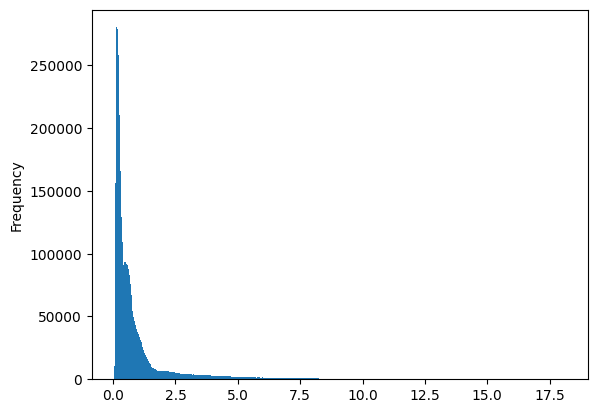

In [4]:
df['consumption'].plot(kind='hist', bins=500)

<Axes: xlabel='measured_at'>

<Axes: xlabel='measured_at'>

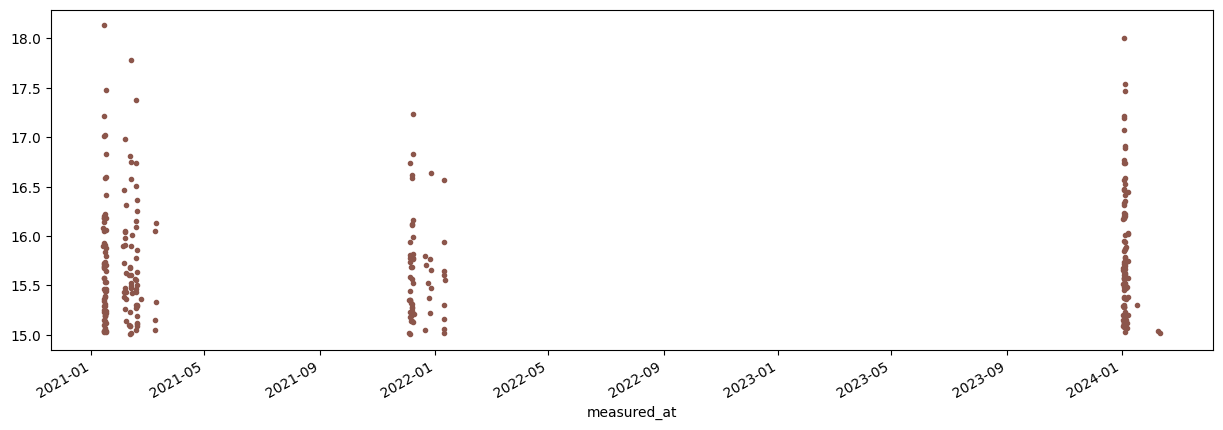

In [153]:
df.query('consumption > 15')['consumption'].plot(figsize=(15, 5),
                                                 style='.',
                                                 color=color_pal[5])

# Feature creation
# 1. time series features


In [11]:
def create_ts_features(df):
    """Create time series features based on time index."""
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

df = create_ts_features(df)

# 2. Lag features
The lags have to be minimum 1 year since we are forecasting for 48 hours as well as 12 months. THis is kind of ass since 1 hour and 1 week lags are really effective.

In [12]:
def add_lag(df):
    df = df.copy()
    # Create lags per group
    for group in df['group_id'].unique():
        group_data = df[df['group_id'] == group].sort_index()
        target_map = group_data['consumption'].to_dict()
        df.loc[df['group_id'] == group, '1h lag'] = (df.loc[df['group_id'] == group].index - pd.Timedelta('1h')).map(target_map)
        df.loc[df['group_id'] == group, '2h lag'] = (df.loc[df['group_id'] == group].index - pd.Timedelta('2h')).map(target_map)
        df.loc[df['group_id'] == group, '1d lag'] = (df.loc[df['group_id'] == group].index - pd.Timedelta('1d')).map(target_map)
        df.loc[df['group_id'] == group, '1y lag'] = (df.loc[df['group_id'] == group].index - pd.Timedelta('364 days')).map(target_map)
    return df

In [13]:
df = add_lag(df)
df = df.sort_index()  # Sort by timestamp (measured_at)


# 3. Statistical features

In [129]:
def add_stats(df):
    df = df.copy()
    df['std_24h'] = df.groupby('group_id')['consumption'].transform(lambda x: x.shift(1).rolling(window=24).std())
    df['mean_24h'] = df.groupby('group_id')['consumption'].transform(lambda x: x.shift(1).rolling(window=24).mean())
    df['max_24h'] = df.groupby('group_id')['consumption'].transform(lambda x: x.shift(1).rolling(window=24).max())
    df['min_24h'] = df.groupby('group_id')['consumption'].transform(lambda x: x.shift(1).rolling(window=24).min())
    return df

# 4. Weather features
Key weather features are:

* Temperature
* Wind
* Humidity
* Rain



In [3]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import time

# 1. Päivitetty lista koordinaateilla
locations = {
    "Etelä-Savo": {"city": "Savonlinna", "lat": 61.8699, "lon": 28.8800},
    "Pohjois-Savo": {"city": "Kuopio", "lat": 62.8924, "lon": 27.6770},
    "Rovaniemi": {"city": "Rovaniemi", "lat": 66.5039, "lon": 25.7294},
    "Lappi": {"city": "Kemi", "lat": 65.7328, "lon": 24.5641},
    "Pohjois-Pohjanmaa": {"city": "Kajaani", "lat": 64.2238, "lon": 27.7278},
    "Kanta-Häme_others": {"city": "Forssa", "lat": 60.8146, "lon": 23.6151},
    "Kanta-Häme": {"city": "Hämeenlinna", "lat": 60.9959, "lon": 24.4643},
    "Päijät_Häme_others": {"city": "Heinola", "lat": 61.2056, "lon": 26.0381},
    "Uusimaa_others": {"city": "Hyvinkää", "lat": 60.6305, "lon": 24.8597},
    "Varsinais-Suomi_others": {"city": "Salo", "lat": 60.3867, "lon": 23.1250},
    "Pirkanmaa_others": {"city": "Nokia", "lat": 61.4779, "lon": 23.5098},
    "Pohjanmaa": {"city": "Seinäjoki", "lat": 62.7903, "lon": 22.8403},
    "Etelä-Pohjanmaa": {"city": "Seinäjoki", "lat": 62.7903, "lon": 22.8403},
    "Keski-Suomi_others": {"city": "Jämsä", "lat": 61.8643, "lon": 25.1900},
    "Joensuu": {"city": "Joensuu", "lat": 62.6010, "lon": 29.7636},
    "Helsinki": {"city": "Helsinki", "lat": 60.1695, "lon": 24.9354},
    "Tampere": {"city": "Tampere", "lat": 61.4978, "lon": 23.7610},
    "Oulu": {"city": "Oulu", "lat": 65.0124, "lon": 25.4682},
    "Turku": {"city": "Turku", "lat": 60.4515, "lon": 22.2666},
    "Lappeenranta": {"city": "Lappeenranta", "lat": 61.0587, "lon": 28.1887},
    "Espoo": {"city": "Espoo", "lat": 60.2055, "lon": 24.6559},
    "Lahti": {"city": "Lahti", "lat": 60.9827, "lon": 25.6612},
    "Vantaa": {"city": "Vantaa", "lat": 60.2941, "lon": 25.0409},
    "Pori": {"city": "Pori", "lat": 61.4851, "lon": 21.7974},
    "Jyväskylä": {"city": "Jyväskylä", "lat": 62.2415, "lon": 25.7209}
}
# Setup
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)
url = "https://archive-api.open-meteo.com/v1/archive"

all_data = []

print(f"Aloitetaan haku {len(locations)} kaupungille...")

for i, (group_name, info) in enumerate(locations.items(), 1):
    
    print(f"[{i}/{len(locations)}] Haetaan: {group_name} ({info['city']})...", end=" ")
    
    params = {
        "latitude": info["lat"],
        "longitude": info["lon"],
        "start_date": "2021-01-01",
        "end_date": "2025-09-30",
        "hourly": ["temperature_2m", "relative_humidity_2m", "rain", "wind_speed_10m"],
        "timezone": "Europe/Helsinki"
    }
    
    try:
        # Tehdään haku
        responses = openmeteo.weather_api(url, params=params)
        response = responses[0]
        
        # Käsitellään data
        hourly = response.Hourly()
        hourly_data = {
            "date": pd.date_range(
                start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
                end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
                freq = pd.Timedelta(seconds = hourly.Interval()),
                inclusive = "left"
            )
        }
        
        hourly_data["Ryhmä"] = group_name
        hourly_data["Kaupunki"] = info["city"]
        hourly_data["Lämpötila (°C)"] = hourly.Variables(0).ValuesAsNumpy()
        hourly_data["Kosteus (%)"] = hourly.Variables(1).ValuesAsNumpy()
        hourly_data["Sade (mm)"] = hourly.Variables(2).ValuesAsNumpy()
        hourly_data["Tuuli (m/s)"] = hourly.Variables(3).ValuesAsNumpy()

        df_loc = pd.DataFrame(data = hourly_data)
        all_data.append(df_loc)
        
        print("OK.") # Kerrotaan käyttäjälle että onnistui

    except Exception as e:
        print(f"\n!!! VIRHE kohdassa {group_name}: {e}")
        # 'continue' varmistaa että silmukka ei katkea, vaan yrittää seuraavaa
        continue 
    
    # --- TÄRKEÄ HIDASTUS ---
    # Odotetaan 2 sekuntia ennen seuraavaa hakua.
    # Jos dataa on paljon, API saattaa vaatia tämän.
    time.sleep(2) 

# Tallennus vasta loopin jälkeen
if all_data:
    print("\nYhdistetään dataa...")
    final_df = pd.concat(all_data)
    final_df.to_csv("saa_data_FINAL.csv", index=False)
    print(f"Valmis! Tallennettu {len(final_df)} riviä tiedostoon saa_data_FINAL.csv")
else:
    print("Mitään dataa ei saatu haettua.")



Aloitetaan haku 25 kaupungille...
[1/25] Haetaan: Etelä-Savo (Savonlinna)... OK.
[2/25] Haetaan: Pohjois-Savo (Kuopio)... OK.
[2/25] Haetaan: Pohjois-Savo (Kuopio)... OK.
[3/25] Haetaan: Rovaniemi (Rovaniemi)... OK.
[3/25] Haetaan: Rovaniemi (Rovaniemi)... OK.
[4/25] Haetaan: Lappi (Kemi)... OK.
[4/25] Haetaan: Lappi (Kemi)... OK.
[5/25] Haetaan: Pohjois-Pohjanmaa (Kajaani)... OK.
[5/25] Haetaan: Pohjois-Pohjanmaa (Kajaani)... OK.
[6/25] Haetaan: Kanta-Häme_others (Forssa)... OK.
[6/25] Haetaan: Kanta-Häme_others (Forssa)... OK.
[7/25] Haetaan: Kanta-Häme (Hämeenlinna)... OK.
[7/25] Haetaan: Kanta-Häme (Hämeenlinna)... OK.
[8/25] Haetaan: Päijät_Häme_others (Heinola)... OK.
[8/25] Haetaan: Päijät_Häme_others (Heinola)... OK.
[9/25] Haetaan: Uusimaa_others (Hyvinkää)... OK.
[9/25] Haetaan: Uusimaa_others (Hyvinkää)... OK.
[10/25] Haetaan: Varsinais-Suomi_others (Salo)... OK.
[10/25] Haetaan: Varsinais-Suomi_others (Salo)... OK.
[11/25] Haetaan: Pirkanmaa_others (Nokia)... OK.
[11/25] Ha

In [14]:

# Sanakirja: "ID_numero": "Säädatan_kaupunki"
# Varmista, että nämä nimet ovat samat kuin säädatan "Kaupunki"-sarakkeessa!
id_to_city_map = {
    "28": "Savonlinna",  # Etelä-Savo
    "29": "Savonlinna",
    "30": "Savonlinna",
    "36": "Joensuu",
    "37": "Joensuu",
    "38": "Joensuu",
    "39": "Joensuu",
    "40": "Joensuu",
    "41": "Joensuu",
    "42": "Joensuu",
    "43": "Joensuu",
    "73": "Joensuu",
    "74": "Joensuu",
    "76": "Joensuu",
    "116": "Kuopio",
    "149": "Kemi",      # Lappi
    "150": "Kemi",
    "151": "Kemi",
    "152": "Kemi",
    "157": "Rovaniemi",
    "196": "Oulu",
    "197": "Oulu",
    "198": "Oulu",
    "199": "Oulu",
    "200": "Oulu",
    "201": "Oulu",
    "213": "Oulu",
    "222": "Kajaani",   # Pohjois-Pohjanmaa
    "225": "Kajaani",
    "231": "Kajaani",
    "233": "Kajaani",
    "234": "Kajaani",
    "235": "Kajaani",
    "237": "Kajaani",
    "238": "Kajaani",
    "270": "Lappeenranta",
    "271": "Lappeenranta",
    "295": "Hämeenlinna",
    "298": "Hämeenlinna",
    "301": "Hämeenlinna",
    "302": "Hämeenlinna",
    "303": "Hämeenlinna",
    "304": "Forssa",      # Kanta-Häme_others
    "305": "Hämeenlinna",
    "307": "Hämeenlinna",
    "308": "Hämeenlinna",
    "346": "Lahti",
    "347": "Lahti",
    "348": "Lahti",
    "378": "Lahti",
    "380": "Heinola",     # Päijät_Häme_others
    "385": "Espoo",
    "387": "Espoo",
    "390": "Espoo",
    "391": "Espoo",
    "393": "Espoo",
    "394": "Espoo",
    "395": "Espoo",
    "396": "Espoo",
    "397": "Espoo",
    "398": "Espoo",
    "399": "Espoo",
    "400": "Espoo",
    "401": "Espoo",
    "402": "Espoo",
    "403": "Espoo",
    "404": "Espoo",
    "405": "Espoo",
    "447": "Hyvinkää",    # Uusimaa_others
    "450": "Hyvinkää",
    "459": "Vantaa",
    "460": "Vantaa",
    "466": "Vantaa",
    "468": "Pori",
    "469": "Pori",
    "538": "Salo",  
    "541": "Salo",  
    "542": "Salo", 
    "561": "Seinäjoki",
    "570": "Seinäjoki",
    "573": "Seinäjoki",
    "577": "Seinäjoki",
    "580": "Seinäjoki",
    "581": "Seinäjoki",
    "582": "Seinäjoki",
    "583": "Seinäjoki",
    "585": "Seinäjoki",
    "586": "Seinäjoki",
    "622": "Jyväskylä",
    "623": "Jyväskylä",
    "624": "Jyväskylä",
    "625": "Jyväskylä",
    "626": "Jyväskylä",
    "657": "Jyväskylä",
    "658": "Jämsä",       # Keski-Suomi_others
    "659": "Jämsä",
    "682": "Nokia",       # Pirkanmaa_others
    "691": "Nokia",
    "692": "Nokia",
    "693": "Nokia",
    "694": "Nokia",
    "695": "Nokia",
    "697": "Nokia",
    "698": "Nokia",
    "705": "Tampere",
    "706": "Tampere",
    "707": "Tampere",
    "708": "Tampere",
    "709": "Tampere",
    "738": "Seinäjoki",
    "740": "Seinäjoki",
    "741": "Seinäjoki"
}

In [15]:

# 1. Lataa säädata (Tämä on se tiedosto, jonka aiempi Open-Meteo koodi loi)
weather_df = pd.read_csv("saa_data_FINAL.csv")

# --- VAIHE A: Valmistele päädataframe (df) ---

# Varmistetaan, että indeksi (measured_at) on sarake, jotta merge on helpompi
# Jos se on jo indeksi (kuten koodissasi set_index teki), resetoidaan se.
df = df.reset_index()

# Muutetaan group_id stringiksi, jotta se täsmää sanakirjan avaimiin ("28", "36" jne.)
# Jos id_to_city_map avaimet ovat stringejä, tämän pitää olla myös.
df['group_id_str'] = df['group_id'].astype(str)

# Lisätään "Kaupunki"-sarake mäppäämällä
df['Kaupunki'] = df['group_id_str'].map(id_to_city_map)

# TARKISTUS: Jos mäppäys epäonnistuu (esim. uusi ID), riville tulee NaN.
# Voit tarkistaa tämän printtaamalla: 
# print(df[df['Kaupunki'].isna()]['group_id'].unique())


# --- VAIHE B: Valmistele säädataframe (weather_df) ---

# Säädatassa on sarake "date", nimetään se samaksi kuin päädatassa
weather_df = weather_df.rename(columns={'date': 'measured_at'})

# Varmistetaan aikaleimojen yhteensopivuus (molemmat UTC-muotoon)
df['measured_at'] = pd.to_datetime(df['measured_at'], utc=True)
weather_df['measured_at'] = pd.to_datetime(weather_df['measured_at'], utc=True)

# Valitaan vain tarvittavat sarakkeet säädatasta (jätetään 'Ryhmä' pois jos turha)
weather_cols = ['measured_at', 'Kaupunki', 'Lämpötila (°C)', 'Kosteus (%)', 'Sade (mm)', 'Tuuli (m/s)']
weather_df_clean = weather_df[weather_cols].copy()


# --- VAIHE C: Yhdistäminen (Merge) ---

# Tehdään "Left Join".
# Tämä tarkoittaa: "Säilytä kaikki df:n rivit, ja hae niille säädata, jos löytyy."
# ... (edellinen merge-koodi) ...

# 1. Tehdään merge
df_final = pd.merge(
    df.reset_index(), # Varmistetaan että aika on sarakkeena
    weather_df_clean, 
    on=['measured_at', 'Kaupunki'], 
    how='left'
)

# 2. Palautetaan group_id kategoriaksi (jos haluat säästää muistia / mallisi vaatii sen)
df_final['group_id'] = df_final['group_id'].astype('category')

# 3. TÄRKEÄ: Palautetaan järjestys (Time -> Group)
# Tämä varmistaa visuaalisesti ja loogisesti saman long-format rakenteen
df_final = df_final.sort_values(by=['measured_at', 'group_id'])

# 4. Asetetaan indeksi takaisin
df_final = df_final.set_index('measured_at')

# Tarkistus: onko rivimäärä sama kuin alussa?
print(f"Alkuperäiset rivit: {len(df)}")
print(f"Lopulliset rivit:   {len(df_final)}")
# Näiden lukujen pitää olla täsmälleen samat.

Alkuperäiset rivit: 3679872
Lopulliset rivit:   4107000


In [16]:
turhat_sarakkeet = ['index', 'level_0', 'Kaupunki', 'group_id_str']
df_final = df_final.drop(columns=turhat_sarakkeet, errors='ignore')

In [17]:
df = df_final

In [38]:
df.to_csv('dataframe', index=True)

# Time series cross validation

The model should capture the seasonality of the time series in the training phase. This is why validating is done for the final year of the data set by 12 1-month test sets. In this method, the model will be tested on every single month of the year, allowing more accurate predictions for the entirety of the seasonal pattern of the time series. Dividing the set into folds allows for better evaluatation of the model's performance and decrease variance between different months.

# Model Creation


In [ ]:
tss = TimeSeriesSplit(n_splits=12, test_size=24*30*112, gap=24)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_ts_features(train)
    test = create_ts_features(test)

    train = add_lag(train)
    test = add_lag(test)

    features = ['group_id', 'eur_per_mwh', 'hour', 'dayofweek', 'month', 'year',
                '1h lag', '2h lag', '1d lag', '1y lag', 'Lämpötila (°C)', 'Kosteus (%)', 'Sade (mm)', 'Tuuli (m/s)']
    
    target = ['consumption']

    X_train = train[features]
    y_train = train[target]

    X_test = test[features]
    y_test = test[target]
    
    reg = lgb.LGBMRegressor(num_leaves=60, n_estimators=5000, learning_rate=0.01, early_stopping_round=50)
    reg.fit(X_train, y_train,
            eval_set=[(X_test, y_test)],
            callbacks=[lgb.log_evaluation(period=100)])
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = mean_absolute_percentage_error(y_test, y_pred)
    scores.append(score)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2301
[LightGBM] [Info] Number of data points in the train set: 3139296, number of used features: 14
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.980501
Training until validation scores don't improve for 50 rounds
[100]	valid_0's l2: 0.645057
[100]	valid_0's l2: 0.645057
[200]	valid_0's l2: 0.104096
[200]	valid_0's l2: 0.104096
[300]	valid_0's l2: 0.0330684
[300]	valid_0's l2: 0.0330684
[400]	valid_0's l2: 0.0231555
[400]	valid_0's l2: 0.0231555
[500]	valid_0's l2: 0.0208594
[500]	valid_0's l2: 0.0208594
[600]	valid_0's l2: 0.0196996
[600]	valid_0's l2: 0.0196996
[700]	valid_0's

In [22]:
scores

[0.04069006176980529,
 0.0378833471698124,
 0.03924471893075507,
 0.049465601875204046,
 0.04063633578268287,
 0.04573524995956747,
 0.04914049047751897,
 0.051714053890109614,
 0.049232291287378084,
 0.05255865613838884,
 0.052025085014483136,
 0.055082110700498406]

# Feature Importance

In [24]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])

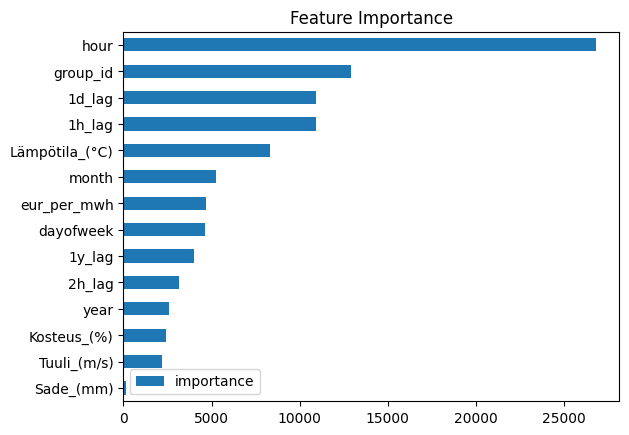

In [25]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test Set

In [26]:
# Make predictions for all 112 groups
test['prediction'] = reg.predict(X_test)

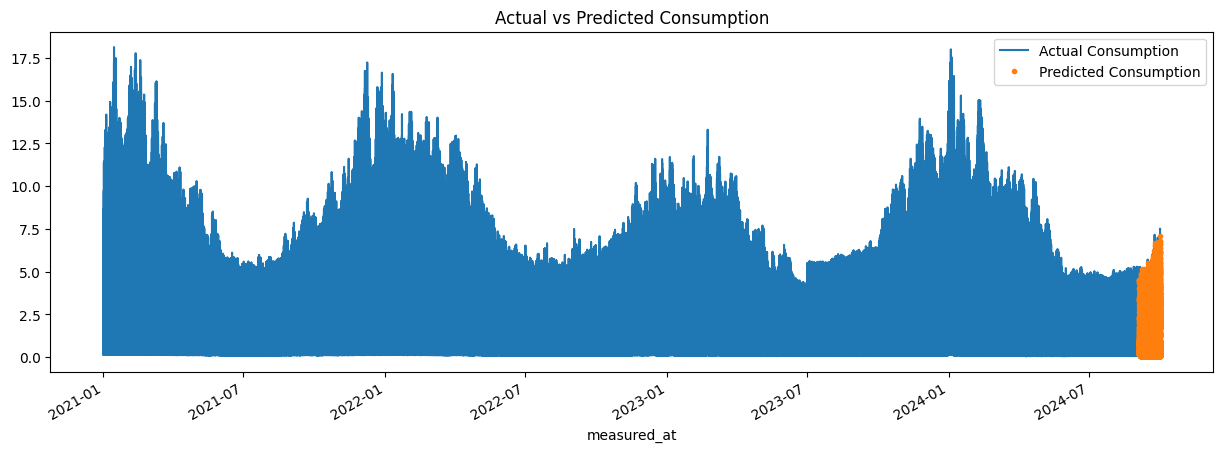

In [27]:
ax = df[['consumption']].plot(figsize=(15, 5))
test['prediction'].plot(ax=ax, style='.')
plt.legend(['Actual Consumption', 'Predicted Consumption'])
ax.set_title('Actual vs Predicted Consumption')
plt.show()

# Metrics

In [23]:
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE on test set: {mae:0.2f}")
print(f"MAPE on test set: {mape:0.2f}")
print(f"RMSE on test set: {rmse:0.2f}")

MAE on test set: 0.03
MAPE on test set: 0.06
RMSE on test set: 0.06


# Worst and best predicted days

In [28]:
test['error'] = np.abs(test['consumption'] - test['prediction'])
test['date'] = test.index.date
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2024-09-04    0.084271
2024-09-30    0.037104
2024-09-21    0.033475
2024-09-23    0.033277
2024-09-24    0.032932
Name: error, dtype: float64

In [29]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

date
2024-09-08    0.020655
2024-09-10    0.021319
2024-09-13    0.021712
2024-09-07    0.022783
2024-09-11    0.023066
Name: error, dtype: float64

# 48 Hour and 12 month forecast

In [36]:
#Actual values for consumption
actual_hourly_path = "/home/anton_s/MyEnergy/EnergyForecastFinal/data/20251111_INTERNAL_actuals_hourly.csv"
actual_monthly_path = "/home/anton_s/MyEnergy/EnergyForecastFinal/data/20251111_INTERNAL_actuals_monthly.csv"

actual_hourly_df = pd.read_csv(actual_hourly_path, sep=';', decimal=',')
actual_monthly_df = pd.read_csv(actual_monthly_path, sep=';', decimal=',')


In [17]:
#Train final model to leverage all data

features = ['group_id', 'eur_per_mwh', 'hour', 'dayofweek', 'month', 'year',
            '1h lag', '2h lag', '1d lag', '1y lag']

X_final = df[features]
y_final = df['consumption']

final_model = lgb.LGBMRegressor(n_estimators=909, learning_rate=0.01)
final_model.fit(X_final, y_final,
                callbacks=[lgb.log_evaluation(period=100)])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.052099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1436
[LightGBM] [Info] Number of data points in the train set: 3679872, number of used features: 10
[LightGBM] [Info] Start training from score 1.007347
[LightGBM] [Info] Start training from score 1.007347


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.01
,n_estimators,909
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [18]:
#48 hour dataframe
dates_df = pd.DataFrame({'measured_at': pd.date_range('2024-10-01T00:00:00.000Z', '2024-10-02T23:00:00.000Z', freq='1h')})
groups_df = pd.DataFrame({'group_id': df['group_id'].unique()})

# 2. Perform a Cross Join (Cartesian Product)
hourly_df = dates_df.merge(groups_df, how='cross')

# 3. Set Index and Fix Types
hourly_df = hourly_df.set_index('measured_at')
hourly_df['group_id'] = hourly_df['group_id'].astype(df['group_id'].dtype)

# 4. Add flags
hourly_df['future_consumption'] = True
df['future_consumption'] = False
df_and_hourly = pd.concat([df, hourly_df])
df_and_hourly = create_ts_features(df_and_hourly)
df_and_hourly = add_lag(df_and_hourly)



In [ ]:
# Simple 48-hour forecast using df_and_hourly with NaN lag handling
# For future timestamps, lags will be NaN - we'll fill them with training mean

# Get mean lag values from training data for imputation
mean_1h_lag = df['1h lag'].mean()
mean_2h_lag = df['2h lag'].mean()
mean_1d_lag = df['1d lag'].mean()

# Prepare forecast dataframe
forecast_df_final = df_and_hourly[df_and_hourly['future_consumption'] == True].copy()

# Fill NaN lags with training means
forecast_df_final['1h lag'] = forecast_df_final['1h lag'].fillna(mean_1h_lag)
forecast_df_final['2h lag'] = forecast_df_final['2h lag'].fillna(mean_2h_lag)
forecast_df_final['1d lag'] = forecast_df_final['1d lag'].fillna(mean_1d_lag)

# Make predictions
features_for_pred = ['group_id', 'eur_per_mwh', 'hour', 'dayofweek', 'month', 'year',
                     '1h lag', '2h lag', '1d lag', '1y lag']
X_forecast = forecast_df_final[features_for_pred]
forecast_df_final['consumption'] = final_model.predict(X_forecast)

print(f"✓ Generated {len(forecast_df_final)} forecast rows (48 hours × {len(df['group_id'].unique())} groups)")
print(f"Forecast range: {forecast_df_final.index.min()} to {forecast_df_final.index.max()}")

NameError: name 'df_and_hourly' is not defined

In [ ]:
hourly_file = forecast_df_final.reset_index()[['measured_at', 'group_id', 'consumption']]

# Convert to wide format
hourly_file_wide = hourly_file.pivot_table(index='measured_at', columns='group_id', values='consumption')


Wide format shape: (48, 112)
group_id                         28        29        30        36        37  \
measured_at                                                                   
2024-10-01 00:00:00+00:00  4.743905  0.106168  0.620944  0.318418  0.110077   
2024-10-01 01:00:00+00:00  2.737298  0.786160  0.912251  0.811286  0.786813   
2024-10-01 02:00:00+00:00  2.891035  0.799833  0.934056  0.826336  0.800116   
2024-10-01 03:00:00+00:00  3.079130  0.806686  0.945165  0.839191  0.807048   
2024-10-01 04:00:00+00:00  3.313096  0.806686  0.947058  0.844697  0.809494   

group_id                         38        39        40        41        42  \
measured_at                                                                   
2024-10-01 00:00:00+00:00  0.415483  0.111395  0.113041  0.504021  0.104229   
2024-10-01 01:00:00+00:00  0.812453  0.786699  0.786270  0.814716  0.784905   
2024-10-01 02:00:00+00:00  0.830541  0.800545  0.800116  0.842379  0.799833   
2024-10-01 03:00:00+00

/tmp/ipykernel_191759/1967798128.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  hourly_file_wide = hourly_file.pivot_table(index='measured_at', columns='group_id', values='consumption')


In [ ]:
# Format and export forecast
hourly_file_wide = hourly_file_wide.reset_index()
hourly_file_wide = hourly_file_wide.applymap(lambda x: str(x).replace('.', ',') if pd.notna(x) else x)


✓ Formatted forecast exported to forecasts/forecast_48h_oct1_oct2_weather.csv


/tmp/ipykernel_191759/393740154.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  hourly_file_wide = hourly_file_wide.applymap(lambda x: str(x).replace('.', ',') if pd.notna(x) else x)
